In [1]:
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('stopwords')
nltk.download("wordnet")
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
%matplotlib inline
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anfang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/anfang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
dataset = pd.read_csv('dataset.csv', index_col = 'Unnamed: 0')
print(dataset.shape)

(24783, 6)


In [3]:
dataset.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [4]:
label =list(dataset['class'].values)
text = list(dataset['tweet'].values)

In [5]:
print(len(label))
print(len(text))

24783
24783


In [6]:
dataset['class'].value_counts()

1    19190
2     4163
0     1430
Name: class, dtype: int64

In [7]:
import os
file_lst = ["aug_data/input_data_2.txt", "aug_data/input_data_0.txt", \
            "aug_data/1_0.txt", "aug_data/2_0.txt", "aug_data/0_0.txt"
           ]
for f in file_lst:
    if os.path.exists(f):
        os.remove(f)

In [8]:
# do basic data preprocess, then generate new data
stemmer = nltk.PorterStemmer()
stopword = set(stopwords.words('english'))
import string
def data_preprocess(review):
    review = re.sub(r"http\S+", '', review) # remove url
    review = re.sub(r'^\s+|\s+?$','',review) # remove leading and trailing whitespace
    review = re.sub(r'@[\w\-]+', '', review) # remove mentions
    review = re.sub(r'RT[\s]+', '', review) #remove retweet text 'RT'
    review = re.sub('[^a-zA-Z]',' ',review)#replace non-character with space
    review = review.lower() #lower the text
    review = re.sub('\[.*?\]', '', review)
    #review = re.sub('https?://\S+|www\.\S+', '', review) # remove hyperlinks
    review = re.sub(r'#', '', review) # remove hashtags
    review = re.sub('[%s]' % re.escape(string.punctuation), '', review) # remove escape characters
    review = re.sub('\n', '', review)
    review = re.sub('\w*\d\w*', '', review)
    review = [word for word in review.split(' ') if word not in stopword and word not in string.punctuation] #remove stopwords and punctuations and tokenize
    review=" ".join(review)
    review = [stemmer.stem(word) for word in review.split(' ')] #use PorterStemmer
    
    review=" ".join(review)
    return review

In [9]:
file2 = open("aug_data/input_data_2.txt", "a")
file0 = open("aug_data/input_data_0.txt", "a")
file1 = open("aug_data/1_0.txt", "a")
for i in range(len(label)):
    new_text = data_preprocess(text[i])
    write_in = str(label[i]) + "\t" + str(new_text) + "\n"
    if label[i] == 2:
        file2.write(write_in)
    if label[i] == 0:
        file0.write(write_in)
    if label[i] == 1:
        file1.write(write_in)
file2.close
file0.close
file1.close

<function TextIOWrapper.close()>

In [10]:
!python aug_code/augment.py --input=aug_data/input_data_2.txt --output=aug_data/2_0.txt --num_aug=4
!python aug_code/augment.py --input=aug_data/input_data_0.txt --output=aug_data/0_0.txt --num_aug=14

generated augmented sentences with eda for aug_data/input_data_2.txt to aug_data/2_0.txt with num_aug=4
generated augmented sentences with eda for aug_data/input_data_0.txt to aug_data/0_0.txt with num_aug=14


In [11]:
!wc -l aug_data/2_0.txt
!wc -l aug_data/0_0.txt

   19995 aug_data/2_0.txt
   19260 aug_data/0_0.txt


In [12]:
processed_aug_data = ["aug_data/2_0.txt",\
                      "aug_data/1_0.txt",\
                     "aug_data/0_0.txt"]

In [34]:
df_csvs = []
for csv_file in processed_aug_data:
    df_tmp = pd.read_table(csv_file, sep="\t", header = None)
    df_csvs.append(df_tmp)
df_aug = pd.concat(df_csvs)
df_aug.dropna(axis=0, how = "any", inplace = True)
df_aug.rename(columns = {0: "class", 1: "processed_tweet"}, inplace = True)

In [35]:
df_aug.head()

,class,processed_tweet
0,2,woman complain clean hous amp man alway pack t...
1,2,woman complain clean hous amp man alway take t...
2,2,woman complain clean hous amp man alway take t...
3,2,charwoman woman complain clean hous amp man al...
4,2,woman complain clean hous amp man alway take t...


In [36]:
y=df_aug['class'].values
y

array([2, 2, 2, ..., 0, 0, 0])

In [37]:
df_aug['class'].value_counts()

2    19995
0    19260
1    19104
Name: class, dtype: int64

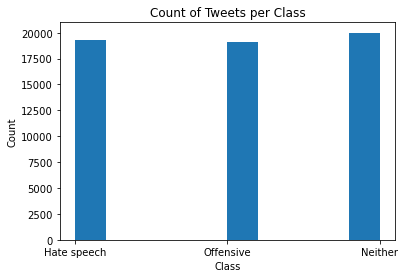

In [38]:
plt.hist(df_aug['class'],align='mid')
col_names=['Hate speech','Offensive',"Neither"]
x_values = np.arange(0, len(col_names))
plt.xticks(x_values, col_names)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Count of Tweets per Class')
plt.show()

In [39]:
df_aug[df_aug['class']==0]['processed_tweet']

0                                    peril gaywad
1                                    queer gaywad
2                              nance queer gaywad
3                                    queer gaywad
4                                    queer gaywad
                           ...                   
19255                 reason shelbi hate sandwich
19256    reason detest shelbi hate sandwich queer
19257           reason hate shelbi sandwich queer
19258         reason shelbi hatred sandwich queer
19259           reason shelbi hate sandwich queer
Name: processed_tweet, Length: 19260, dtype: object

In [40]:
#Sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sentimentanalyzer
import nltk
nltk.download('vader_lexicon')

sentiment_analyzer = sentimentanalyzer()

def sentiment_analysis(tweet):   
    sentiment = sentiment_analyzer.polarity_scores(tweet)    
    features = [sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound']]
    return features

def sentiment_analysis_array(tweets):
    features=[]
    for t in tweets:
        features.append(sentiment_analysis(str(t)))
    return np.array(features)

sentiment_features_0 = sentiment_analysis_array(df_aug[df_aug['class']==0]['processed_tweet'])
new_features_0 = pd.DataFrame({'Neg':sentiment_features_0[:,0],'Pos':sentiment_features_0[:,1],'Neu':sentiment_features_0[:,2],'Compound':sentiment_features_0[:,3]})

sentiment_features_1 = sentiment_analysis_array(df_aug[df_aug['class']==1]['processed_tweet'])
new_features_1 = pd.DataFrame({'Neg':sentiment_features_1[:,0],'Pos':sentiment_features_1[:,1],'Neu':sentiment_features_1[:,2],'Compound':sentiment_features_1[:,3]})

sentiment_features_2 = sentiment_analysis_array(df_aug[df_aug['class']==2]['processed_tweet'])
new_features_2 = pd.DataFrame({'Neg':sentiment_features_2[:,0],'Pos':sentiment_features_2[:,1],'Neu':sentiment_features_2[:,2],'Compound':sentiment_features_2[:,3]})

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/anfang/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [41]:
new_features_0.mean(axis=0)

Neg         0.386740
Pos         0.098480
Neu         0.514726
Compound   -0.386943
dtype: float64

In [42]:
new_features_1.mean(axis=0)

Neg         0.377120
Pos         0.122394
Neu         0.500488
Compound   -0.349304
dtype: float64

In [43]:
new_features_2.mean(axis=0)

Neg         0.081442
Pos         0.140011
Neu         0.778548
Compound    0.073570
dtype: float64

In [44]:
# Count Vector
from sklearn.feature_extraction.text import CountVectorizer    
cv=CountVectorizer(max_features=3600)
cv=cv.fit_transform(df_aug['processed_tweet'])
cv_features = cv.toarray()

In [45]:
#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)
tfidf = tfidf_vectorizer.fit_transform(df_aug['processed_tweet'])
tfidf_features = tfidf.toarray()

In [46]:
#Doc2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df_aug["processed_tweet"].apply(lambda x: x.split(" ")))]
doc2vec_model = Doc2Vec(documents,vector_size=5, window=2, min_count=1, workers=4)
doc2vec_features = df_aug["processed_tweet"].apply(lambda x: doc2vec_model.infer_vector(x.split(" "))).apply(pd.Series)
#doc2vec_features.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_features.columns]

In [48]:
#sentiment analysis features
sa_features = pd.concat([new_features_0,new_features_1,new_features_2], ignore_index=True)

In [49]:
total_features = np.concatenate([pd.DataFrame(cv_features),pd.DataFrame(tfidf_features),sa_features,doc2vec_features],axis=1)

In [50]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(cv_features, y, test_size = 0.1, random_state=0)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_features, y, test_size = 0.1, random_state=0)
X_train_d2v, X_test_d2v, y_train_d2v, y_test_d2v = train_test_split(doc2vec_features, y, test_size = 0.1, random_state=0)
X_train_sa, X_test_sa, y_train_sa, y_test_sa = train_test_split(sa_features, y, test_size = 0.1, random_state=0)
X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(total_features, y, test_size = 0.1, random_state=0)

#X_train_cv.shape, X_test_cv.shape
splited_data= [(X_train_cv,y_train_cv,X_test_cv, y_test_cv), (X_train_sa,y_train_sa,X_test_sa, y_test_sa),\
              (X_train_tfidf,y_train_tfidf,X_test_tfidf, y_test_tfidf), (X_train_d2v,y_train_d2v,X_test_d2v, y_test_d2v),\
              (X_train_total,y_train_total,X_test_total, y_test_total)]

In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn
feature_list = ['count vector', "sentimental analysis", "tf-idf", "doc2vec", "combination"]

def result_evaluation(cm, y_test, pred, index, title):
    matrix_proportions = np.zeros((3,3))
    for i in range(0,3):
        matrix_proportions[i,:] = cm[i,:]/float(cm[i,:].sum())
    names=['Hate','Offensive','Neither']
    confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
    ax = plt.subplot(2, 3, index+1)
    ax = seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
    ax.set_title(title)
    
    metrics_table['Accuracy score'].append(accuracy_score(y_test, pred))
    metrics_table['Precision score'].append(precision_score(y_test, pred,average='weighted'))
    metrics_table['Recall score'].append(recall_score(y_test, pred,average='weighted'))
    metrics_table["f1 score"].append(f1_score(y_test, pred,average='weighted'))

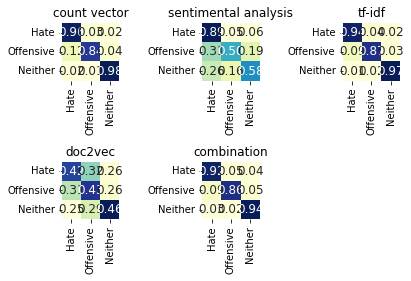

,Accuracy score,Precision score,Recall score,f1 score
count vector,0.925463,0.928363,0.925463,0.924858
sentimental analysis,0.658328,0.673160,0.658328,0.649043
tf-idf,0.928547,0.929108,0.928547,0.928184
doc2vec,0.437457,0.438154,0.437457,0.437681
combination,0.906957,0.907501,0.906957,0.906706


In [52]:
from sklearn.tree import DecisionTreeClassifier

metrics_table = {
    'Accuracy score':[],
    'Precision score':[],
    'Recall score':[],
    'f1 score':[]
}

for i in range(len(splited_data)):
    data = splited_data[i]
    classifier = DecisionTreeClassifier()
    classifier.fit(data[0], data[1])
    pred = classifier.predict(data[2])
    cm = confusion_matrix(data[3],pred)
    title = feature_list[i]
    result_evaluation(cm, data[3], pred, i, title)

plt.tight_layout()     
plt.show()  
metrics_table = pd.DataFrame(metrics_table, index = feature_list)
metrics_table